# Merging distance optimization

In [290]:
import pybedtools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pybedtools.featurefuncs import midpoint
from sklearn.metrics import silhouette_samples



In [291]:
min_dist = 60_000
max_dist = 500_000
step = 10_000


scratch_path = '/media/kratka/DATA1/scratch'
chr_sizes = 'data/chr_sizes/Lsyl_chr_sizes.tsv'
pybedtools.set_tempdir(scratch_path)

def calculate_silhouette_scores(bed_centers, merged_bed):
    silhouette_scores = []
    bed_labels = bed_centers.intersect(merged_bed, loj=True)
    # concatenate last three columns
    bed_labels = bed_labels.each(lambda x: x[0:3] + [x[3] + '_' + x[4] +'_'+ x[5]]).saveas()
    # make a list of seqnames
    seqnames = set([x.chrom for x in bed_labels])
    for seqname in seqnames:
        features_on_seq = bed_labels.filter(lambda x: x.chrom == seqname).saveas()
        coordinates = [x.end for x in features_on_seq]
        labels = [x[-1] for x in features_on_seq]
        # reshape
        coordinates = np.array(coordinates).reshape(-1, 1)
        labels = np.array(labels)

        silhouette_scores_chrom = silhouette_samples(coordinates, labels)
        silhouette_scores.extend(silhouette_scores_chrom)
 
    return silhouette_scores
        

def calculate_squares(bed_centers, merged_bed):
    squares = []
    bed_labels = bed_centers.intersect(merged_bed, loj=True)

    # make a list of seqnames
    seqnames = set([x.chrom for x in bed_labels])
    for seqname in seqnames:
        features_on_seq = bed_labels.filter(lambda x: x.chrom == seqname).saveas()
        # calculate center of the unit
        features_on_seq = bed_labels.each(lambda x: x[0:3] + [(int(x[4]) + (int(x[5])))//2]).saveas()
        coordinates = [x.end for x in features_on_seq]
        unit_centers = [int(x[-1]) for x in features_on_seq]
        # reshape
        squares = abs(np.array(coordinates) - np.array(unit_centers))**2
 
    return squares  


In [298]:
def generate_plots(bed_path, candidates=None):
    # calculate silhouette and sum of squares metrics
    bed = pybedtools.BedTool(bed_path).sort()
    bed_centers = bed.each(midpoint).saveas()
    score_dict = {}
    sum_of_squares_dict = {}
    for dist in range(min_dist, max_dist + step, step):
        merged_bed = bed.merge(d=dist)
        silhouette_scores = calculate_silhouette_scores(bed_centers, merged_bed)
        score_dict[dist] = silhouette_scores
        squares = calculate_squares(bed_centers, merged_bed)
        sum_of_squares_dict[dist] = squares

    # figure size
    plt.figure(figsize=(15, 10))
    # Boxplot of silhouette scores
    plt.subplot(2, 2, 1)
    df = pd.DataFrame.from_dict(score_dict)
    df_melted = df.melt(var_name='distance', value_name='silhouette_score')
    # clusters containing only one peak are not considered, since their silhouette score is 0
    df_melted = df_melted[df_melted['silhouette_score'] != 0]
    sns.boxplot(x='distance', y='silhouette_score', data=df_melted)
    plt.xticks(rotation=90)
    plt.title('Boxplot of Silhouette Scores')

    # Line plot of numbers of merged peaks
    plt.subplot(2, 2, 2)
    counts = df_melted['distance'].value_counts().sort_index()
    ax = sns.lineplot(x=counts.index, y=counts.values, color='orange', marker='o')
    ax.set_xticks(counts.index)
    ax.set_xticklabels(counts.index, rotation=90)
    ax.set_xlabel('distance')
    ax.set_ylabel('Number of merged peaks')
    plt.title('Line Plot of Merged Peaks')

    # Line plot of sum of squares
    plt.subplot(2, 2, 3)
    df_squares = pd.DataFrame.from_dict(sum_of_squares_dict)
    df_sums_of_squares = df_squares.sum(axis=0)
    ax = sns.lineplot(x=df_sums_of_squares.index, y=df_sums_of_squares.values, color='green', marker='o')
    ax.set_xticks(df_sums_of_squares.index)
    ax.set_xticklabels(df_sums_of_squares.index, rotation=90)
    ax.set_xlabel('distance')
    ax.set_ylabel('Sum of squares')
    plt.title('Line Plot of Sum of Squares')

    # Histogram of gaps
    plt.subplot(2, 2, 4)
    gaps = bed.complement(g=chr_sizes)
    gap_sizes = [(x.stop - x.start) for x in gaps]
    gap_sizes = np.log10(gap_sizes)
    plt.hist(gap_sizes, bins=100)
    xticks = plt.xticks()[0]
    xticks_labels = [int(10**x) for x in xticks]
    plt.xticks(xticks, xticks_labels)
    plt.xlabel('Gap size')
    plt.ylabel('Frequency')
    for i, value in enumerate(candidates or [min_dist, (min_dist + max_dist) // 2, max_dist]):
        colors = ['red', 'orange', 'yellow', 'green']
        plt.axvline(x=np.log10(value), color=colors[i] if i < len(colors) else 'grey')
    plt.title('Histogram of Gap Sizes')

    plt.tight_layout()
    plt.show()

# CenH3
**It is important to merge centromeric units that are disrupted due to imperfect peak calling, since we will study the size of centromeric units**

distances <90k seem to be lower than optimal based on the silhoutte scores

distances >290k seem to be too high based on the sum of squares

100k-150k seems optimal based on silhouette scores and gap size distribution

150k is the middle point between two peaks of the gap size distribution - it's not clear whether the bimodal distribution of gap sizes distinguishes between gaps caused by imperfect ChIP-seq signal and real centromeric unit spacing

NOTE: On the gaps histogram, there are some <50k - these are not gaps between centromeric units (input peaks were already merged with distance 50kb), but the gaps between the centromeric unit and chromosome end


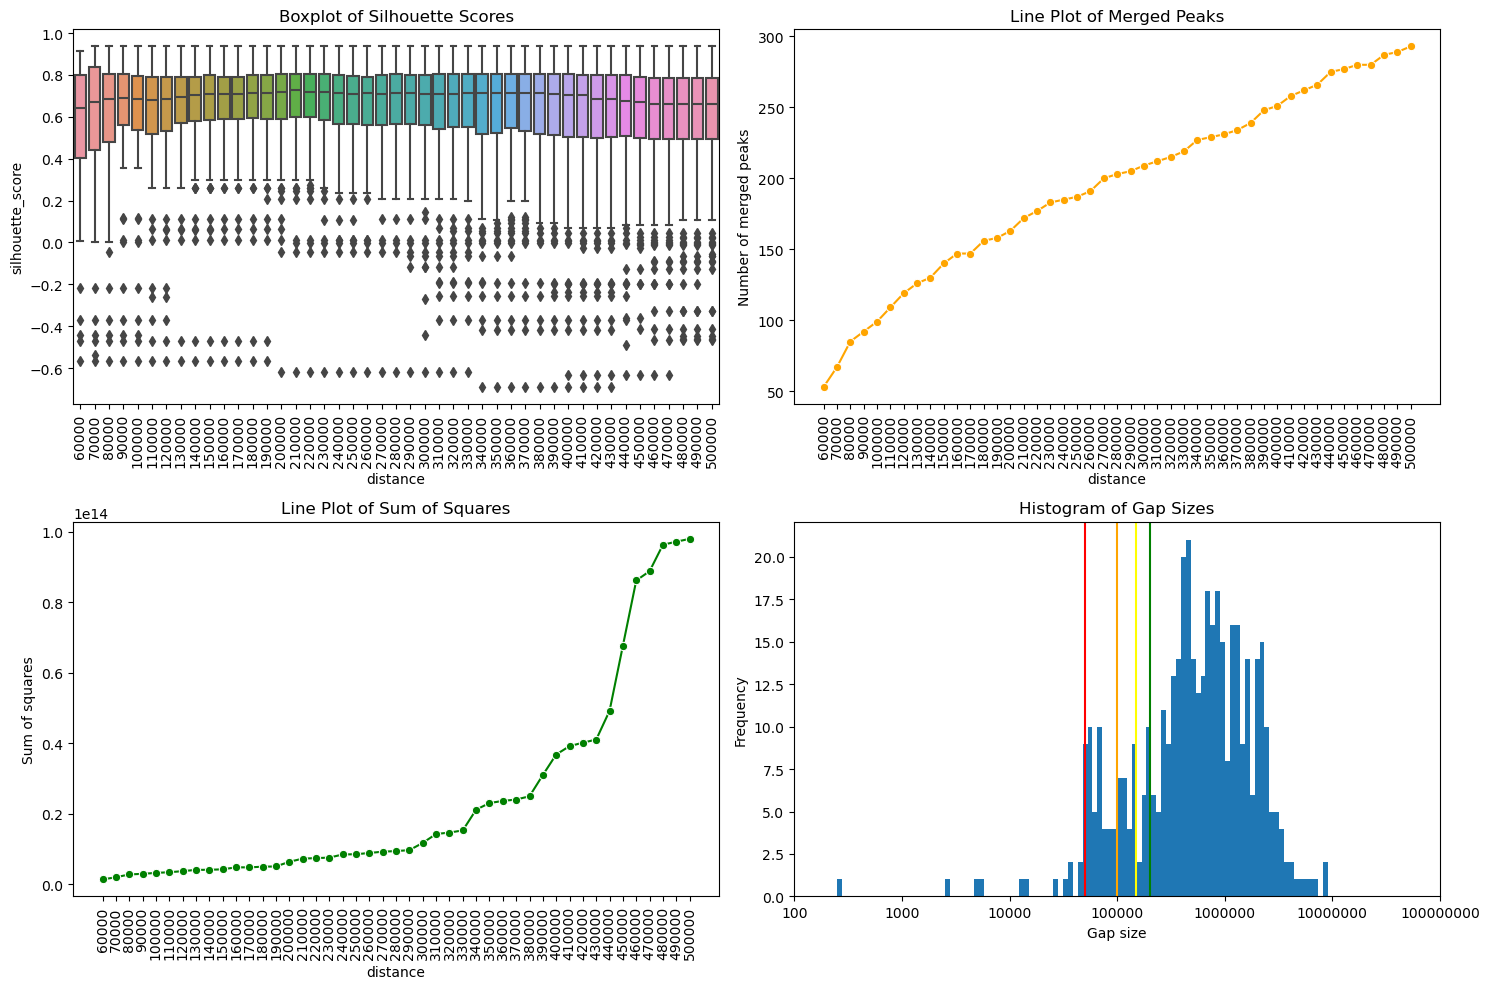

In [303]:
bed_path = 'data/chip-seq/consensus_peaks/CenH3_peaks.bed'
# bed_path = 'data/peaks/Lsyl-CENH3-merged-epic50kb-macs3-peaks.bed'

generate_plots(bed_path, candidates=[50_000,100_000, 150_000, 200_000])


# H3K4me3

Histone modification peaks will be only used for correlation analysis, so it is not neccessary to merge disrupted units perfectly - also the distribution of this mark does not form distinct units like CenH3

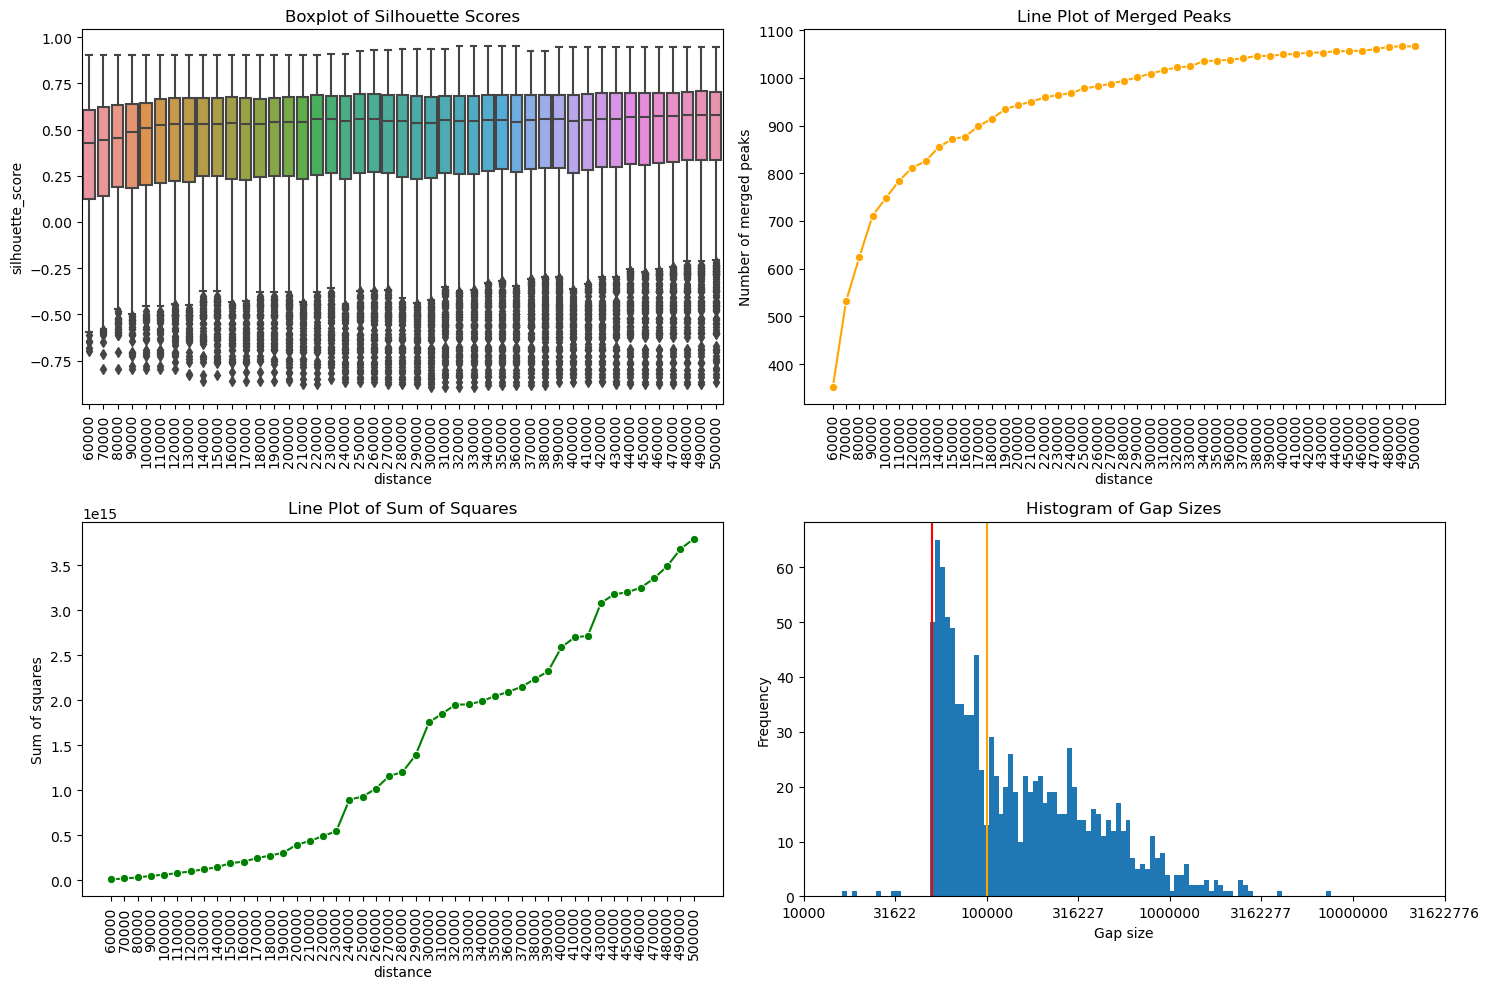

In [300]:
bed_path = 'data/chip-seq/consensus_peaks/H3K4_peaks.bed'
generate_plots(bed_path, candidates=[50_000, 100_000])

# H3K9me2

***** WARNING: HiC_scaffold_5:78938000-78954799 exceeds the length of chromosome (HiC_scaffold_5)


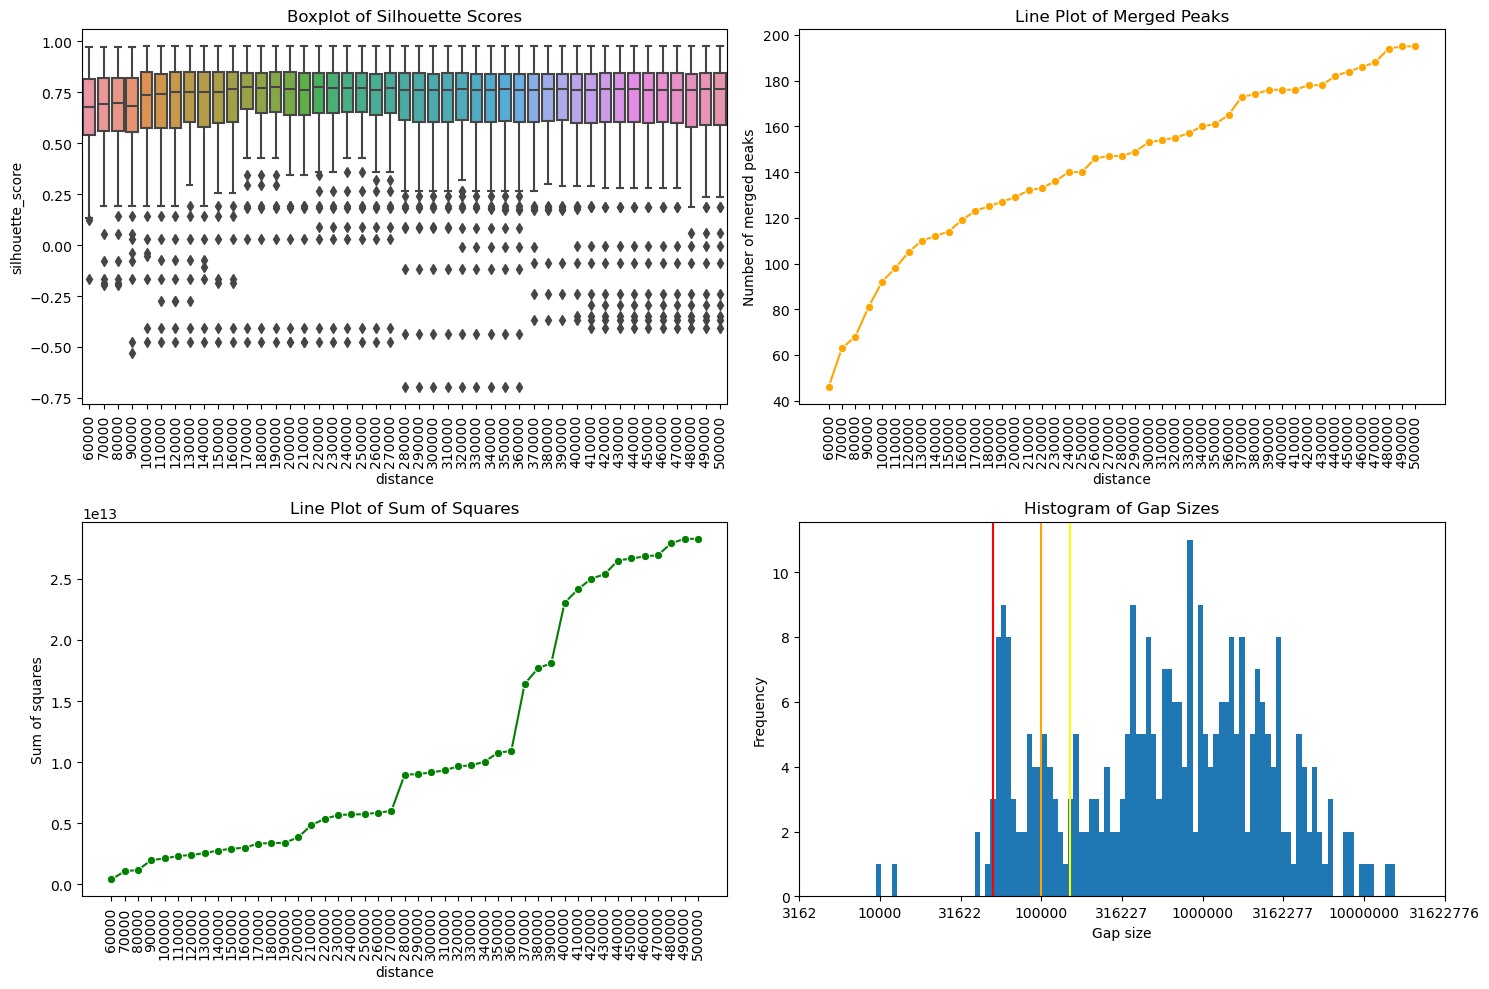

In [302]:
bed_path = 'data/chip-seq/consensus_peaks/H3K9_peaks.bed'
generate_plots(bed_path, candidates=[50_000, 100_000, 150_000])